In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


['list-of-fake-samples-and-public-private-lb-split', 'santander-customer-transaction-prediction']


In [2]:
DEBUG = False

if DEBUG:
    NROWS = 10000
else:
    NROWS = None

train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv', nrows=NROWS)
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv', nrows=NROWS)    

In [3]:
test_df.shape, train_df.shape

((200000, 201), (200000, 202))

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
private_LB = np.load('../input/list-of-fake-samples-and-public-private-lb-split/private_LB.npy')
public_LB = np.load('../input/list-of-fake-samples-and-public-private-lb-split/public_LB.npy')

print(len(public_LB))
print(len(private_LB))

test_index = list(public_LB) + list(private_LB) 

print(len(test_index))
print(len(np.unique(test_index)))

50000
50000
100000
100000


In [7]:

idcode = test_df.ID_code

print('before test=', len(test_df))

if not DEBUG:
    test_df = test_df.loc[test_index]

print('after test=', len(test_df))

before test= 200000
after test= 100000


In [8]:
def add_count2(df1,df2, cols):    
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        
        nm=col + "_Count"
        
        vc=df.value_counts().to_dict()
        df1[nm]=df1[col].map(vc)
        df2[nm]=df2[col].map(vc)
        df1[nm]=df1[nm].astype('float32')
        df2[nm]=df2[nm].astype('float32')

In [9]:
def add_target2(train, test, cols, encode):    
    for col in cols:
        target_sum = train.groupby(col)['target'].mean()
        nm = col + "_rate"
        train[nm] = train[[col, col + encode]].apply(lambda x: (target_sum[x[0]] / x[1]), axis=1)
        
        index = test[col].isin(train[col])
        test[nm] = 0.5
        test[nm].loc[index] = test[[col, col + encode]].loc[index].apply(lambda x: (target_sum[x[0]] / x[1]), axis=1)

In [10]:
def add_target(train, test, cols, encode):    
    for col in cols:
        target_sum = train.groupby(col)['target'].sum()
        nm = col + "_rate"
        train[nm] = train[[col, col + encode]].apply(lambda x: (target_sum[x[0]] / x[1]), axis=1)
        
        index = test[col].isin(train[col])
        test[nm] = 0.5
        test[nm].loc[index] = test[[col, col + encode]].loc[index].apply(lambda x: (target_sum[x[0]] / x[1]), axis=1)

In [11]:
def add_hist(df1, df2, cols, isplot=False):
    N=50
    #cols = [c for c in df1.columns if c not in ['ID_code', 'target']]
    
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        nm = col + "_Hist"
        hist, bins = np.histogram(df.values, bins=N)
        if isplot:
            fig, ax = plt.subplots(1, 1, figsize=(10, 4))
            plt.plot(hist)
            plt.title(col)
            plt.show()

        index1 = [np.searchsorted(bins, v) -1 for v in df1[col].values]
        index2 = [np.searchsorted(bins, v) -1 for v in df2[col].values]
        
        df1[nm] = hist[index1]
        df2[nm] = hist[index2]

a = np.random.randn(1000) + 100
N=100
hist, bins = np.histogram(a, bins=N)
index = [np.searchsorted(bins, v) -1 for v in a]
plt.plot(a, hist[index])
#hist_v = [hist[ np.searchsorted(bins, v)] for v in a ]
#hist_v
d = [0, 1, 2]
print( np.searchsorted(d, 0.1, side='right'))
print( np.searchsorted(d, 1.1, side='right'))
print( np.searchsorted(d, 2.1, side='right'))




In [12]:
cols = [c for c in train_df.columns if c not in ['ID_code', 'target']]
add_hist(train_df, test_df, cols)
#add_count2(train_df, test_df, cols)

col = 'var_0'

train_df[[col, col + "_Count"]]

target_sum = train_df.groupby(col)['target'].sum()
nm = col + "_rate"
        
train_df[nm] = train_df[[col, col + '_Count']].apply(lambda x: (target_sum[x[0]] / x[1]), axis=1)
train_df[col+"_sum"] = train_df[col].apply(lambda x: (target_sum[x]))


In [13]:
def add_target_hist(train, test):
    cols = [c for c in train.columns if c.count('Hist') > 0]
    for col in cols:
        label_mean = train.groupby(col).target.mean()
        train[col + "_rate"] = train[col].map(label_mean)
        test[col + "_rate"] = test[col].map(label_mean)

In [14]:
add_target_hist(train_df, test_df)

In [15]:
col='var_0'
train_df[train_df.target>0][[col, 'target', col + "_rate"]]

KeyError: "['var_0_rate'] not in index"

In [16]:
train_df.to_csv('train_rate.csv')
test_df.to_csv('test_rate.csv')

In [17]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160_Hist_rate,var_161_Hist_rate,var_162_Hist_rate,var_163_Hist_rate,var_164_Hist_rate,var_165_Hist_rate,var_166_Hist_rate,var_167_Hist_rate,var_168_Hist_rate,var_169_Hist_rate,var_170_Hist_rate,var_171_Hist_rate,var_172_Hist_rate,var_173_Hist_rate,var_174_Hist_rate,var_175_Hist_rate,var_176_Hist_rate,var_177_Hist_rate,var_178_Hist_rate,var_179_Hist_rate,var_180_Hist_rate,var_181_Hist_rate,var_182_Hist_rate,var_183_Hist_rate,var_184_Hist_rate,var_185_Hist_rate,var_186_Hist_rate,var_187_Hist_rate,var_188_Hist_rate,var_189_Hist_rate,var_190_Hist_rate,var_191_Hist_rate,var_192_Hist_rate,var_193_Hist_rate,var_194_Hist_rate,var_195_Hist_rate,var_196_Hist_rate,var_197_Hist_rate,var_198_Hist_rate,var_199_Hist_rate
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,0.100588,0.099380,0.087235,0.090813,0.131197,0.117772,0.102664,0.102848,0.110866,0.101279,0.089170,0.099043,0.094032,0.096922,0.098499,0.095816,0.093963,0.097041,0.104451,0.092719,0.094903,0.095366,0.094405,0.096648,0.105275,0.107298,0.094691,0.092800,0.089310,0.100742,0.098242,0.090703,0.086445,0.106072,0.103765,0.092646,0.102286,0.102507,0.102973,0.103756
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,0.104865,0.103748,0.096656,0.105066,0.101132,0.106278,0.087788,0.130927,0.099175,0.081275,0.109942,0.105922,0.091718,0.103981,0.089532,0.094359,0.102023,0.084863,0.104699,0.173684,0.092829,0.098321,0.102365,0.103042,0.104426,0.102017,0.101730,0.101396,0.104872,0.095895,0.108183,0.087497,0.085266,0.099091,0.101703,0.113227,0.099460,0.096519,0.087826,0.097550
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,0.097319,0.096622,0.094346,0.091951,0.099977,0.093369,0.077366,0.095843,0.094468,0.085455,0.086151,0.098239,0.115978,0.088894,0.084280,0.090781,0.101733,0.095130,0.106430,0.091429,0.092656,0.098321,0.100417,0.104311,0.104289,0.102017,0.112434,0.102399,0.109964,0.095563,0.091729,0.101322,0.102984,0.106072,0.096779,0.147397,0.095224,0.104612,0.102014,0.099809
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,0.096182,0.100341,0.109477,0.093988,0.091398,0.104234,0.106629,0.096632,0.101767,0.103448,0.086151,0.092797,0.096860,0.179416,0.105331,0.095173,0.108409,0.097041,0.099350,0.112094,0.091348,0.102885,0.099431,0.100551,0.084030,0.097064,0.102273,0.098779,0.097497,0.105649,0.098242,0.088246,0.107259,0.100817,0.090376,0.098078,0.092419,0.089107,0.087103,0.100406
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,0.098495,0.097607,0.103355,0.109526,0.131197

In [18]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160_Hist_rate,var_161_Hist_rate,var_162_Hist_rate,var_163_Hist_rate,var_164_Hist_rate,var_165_Hist_rate,var_166_Hist_rate,var_167_Hist_rate,var_168_Hist_rate,var_169_Hist_rate,var_170_Hist_rate,var_171_Hist_rate,var_172_Hist_rate,var_173_Hist_rate,var_174_Hist_rate,var_175_Hist_rate,var_176_Hist_rate,var_177_Hist_rate,var_178_Hist_rate,var_179_Hist_rate,var_180_Hist_rate,var_181_Hist_rate,var_182_Hist_rate,var_183_Hist_rate,var_184_Hist_rate,var_185_Hist_rate,var_186_Hist_rate,var_187_Hist_rate,var_188_Hist_rate,var_189_Hist_rate,var_190_Hist_rate,var_191_Hist_rate,var_192_Hist_rate,var_193_Hist_rate,var_194_Hist_rate,var_195_Hist_rate,var_196_Hist_rate,var_197_Hist_rate,var_198_Hist_rate,var_199_Hist_rate
131076,test_131076,9.2554,-1.0297,11.1124,6.4313,11.3314,-12.7266,6.3105,16.3000,-2.3239,8.1701,-0.9194,-3.8085,13.8883,12.1832,6.8755,14.5551,7.7932,10.3964,3.9239,8.5904,12.4542,10.7429,5.5596,2.8934,10.3618,13.8781,-7.8877,-0.4800,6.7889,6.1813,-13.8250,10.0494,3.9388,17.4255,11.2187,-8.4302,6.3973,3.9340,16.1997,...,0.101576,0.101240,0.110172,0.092534,0.089722,0.083731,0.106730,0.108831,0.089712,0.101279,0.090293,0.101808,0.095413,0.097857,0.089532,0.101930,0.101733,0.101035,0.119048,0.093929,0.096685,0.103183,0.214286,0.103042,0.079882,0.102017,0.091618,0.098300,0.090737,0.095895,0.092435,0.090703,0.110129,0.104756,0.096779,0.101743,0.099460,0.100621,0.089569,0.096614
131078,test_131078,8.1264,-6.3244,12.0427,10.5956,13.0515,2.4566,3.5076,15.2741,0.2167,7.0154,-10.2625,4.0957,14.1607,7.6607,4.3894,15.0278,12.1419,-4.6530,20.3359,14.0115,9.5113,25.4857,2.1740,3.1060,5.6991,13.9659,-1.7591,-1.0374,4.5730,1.8001,-5.1953,13.2347,-0.1838,11.5452,11.4025,5.8216,-3.1038,4.7405,9.0287,...,0.102373,0.099102,0.099014,0.098805,0.099900,0.100530,0.100230,0.102848,0.091259,0.102907,0.092663,0.101507,0.095482,0.096922,0.092646,0.106079,0.112603,0.121265,0.104451,0.091429,0.095865,0.102885,0.100297,0.095516,0.104426,0.098744,0.094224,0.098300,0.094066,0.099247,0.190265,0.090696,0.092406,0.097817,0.117599,0.098078,0.104611,0.093231,0.091015,0.102955
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,...,0.098495,0.103471,0.091274,0.095713,0.102633,0.157199,0.087788,0.088243,0.102496,0.095617,0.102705,0.101161,0.091911,0.109772,0.100601,0.103786,0.101883,0.095265,0.109748,0.086384,0.104072,0.098321,0.106615,0.103042,0.107252,0.100686,0.100889,0.099792,0.097478,0.095649,0.098242,0.088675,0.109514,0.106072,0.101703,0.096992,0.103550,0.084239,0.079602,0.099809
131080,test_131080,11.8092,3.5175,7.2401,7.0770,11.4143,-14.7267,5.6070,12.5889,-0.4833,6.0718,-10.7962,-10.9915,13.8137,10.0909,6.2018,15.3058,8.8374,-2.3552,4.1609,10.2633,16.6368,15.3485,3.9276,3.9124,9.3382,13.4664,-1.5970,-2.5412,6.1347,1.1183,-9.3543,13.5586,-0.2889,22.3350,11.7592,1.4795,5.0948,7.9961,4.6539,...,0.100588,0.103471,0.126595,0.091370,0.102633,0.092960,0.105381,0.091070,0.098480,0.110961,0.102721,0.122239,0.091718,0.090682,0.087609,0.103786,0.091787,0.104503,0.093071,0.092789,0.100559,0.103183,0.104071,0.102664,0.100254,0.096351,0.098420,0.100217,0.094140,0.102650,0.108570,0.109108,0.122520,0.097023,0.100418,0.095336,0.098571,0.104612,0.091015,0.098901
131081,test_131081,8.5003,1.9545,7.6174,5.8388,11.2791,-9.4543,5.4782,17.9878,-1.9208,7.1584,-6.4168,0.6173,13.7854,11.3747,6.3913,14.8312,11.5819,-7.3758,12.0752,29.7073,16.9053,6.2939,0.0961,3.2577,18.1708,13.2992,-9.3249,-1.6044,5.2304,1.4325,-5.7249,13.0200,0.9294,15.0573,11.5555,6.809

In [19]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [20]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.33,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.04,
    'learning_rate': 0.008,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

In [21]:
num_round = 1000000
# check random state 44000
n_fold = 12
folds = StratifiedKFold(n_splits=n_fold, shuffle=False, random_state=12345)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [22]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:60].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    
    feature_importance_df_.to_pickle('importance.pkl')

In [23]:
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3500)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.883814	valid_1's auc: 0.8652
[2000]	training's auc: 0.903826	valid_1's auc: 0.881901
[3000]	training's auc: 0.916061	valid_1's auc: 0.891869
[4000]	training's auc: 0.924252	valid_1's auc: 0.897782
[5000]	training's auc: 0.930398	valid_1's auc: 0.901797
[6000]	training's auc: 0.935226	valid_1's auc: 0.90431
[7000]	training's auc: 0.939241	valid_1's auc: 0.905936
[8000]	training's auc: 0.942785	valid_1's auc: 0.907026
[9000]	training's auc: 0.945972	valid_1's auc: 0.907904
[10000]	training's auc: 0.948944	valid_1's auc: 0.908167
[11000]	training's auc: 0.951757	valid_1's auc: 0.908561
[12000]	training's auc: 0.954415	valid_1's auc: 0.908588
[13000]	training's auc: 0.956912	valid_1's auc: 0.908643
[14000]	training's auc: 0.959357	valid_1's auc: 0.908739
[15000]	training's auc: 0.961716	valid_1's auc: 0.908684
[16000]	training's auc: 0.96393	valid_1's auc: 0.9087
[17000]	training's auc: 0.966104

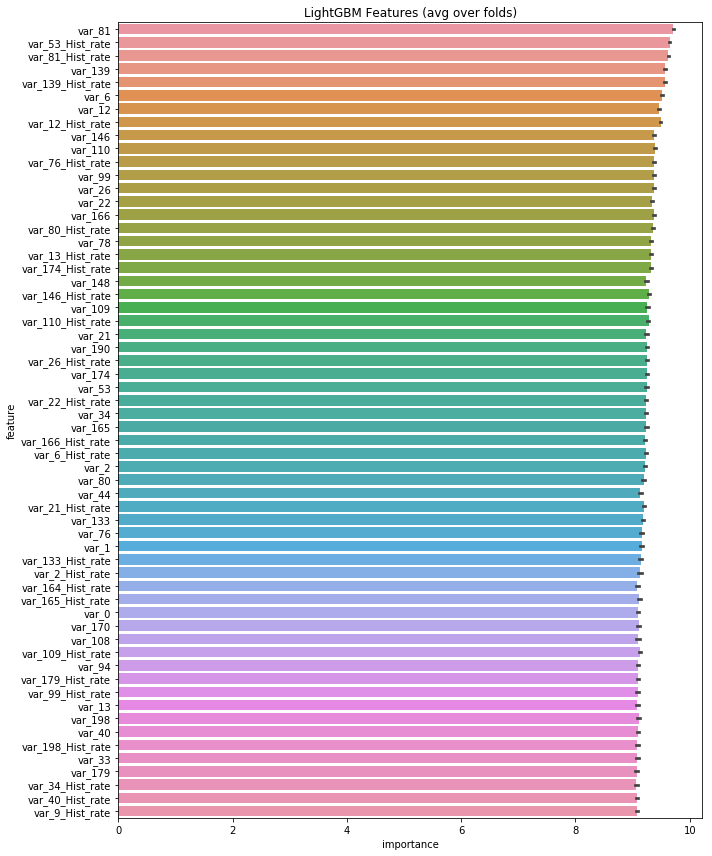

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
display_importances(feature_importance_df)

In [25]:
submission = pd.DataFrame({"ID_code": idcode.values})
submission["target"] = 0
submission["target"].loc[test_index] = predictions
submission.to_csv("submission.csv", index=False)

In [26]:
submission.loc[test_index].head()


,ID_code,target
131076,test_131076,0.003624
131078,test_131078,0.011765
7,test_7,0.204599
131080,test_131080,0.160139
131081,test_131081,0.038228


In [27]:
np.save('pred.data',predictions)

# Notes

param = {
    'bagging_freq': 5,          'bagging_fraction': 0.33,   'boost_from_average':'false',   'boost': 'gbdt',
    'feature_fraction': 0.04,   'learning_rate': 0.008,     'max_depth': -1,                'metric':'auc',
    'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
    'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}

**LB = 0.9**
**CV AUC = 0.90022**